In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
import re
import nethelp as nh
import powerlaw
from collections import Counter
import community
import pickle
import graph_tool.all as gt

In [2]:
def extract_years(date_string):
    """
    Extracts start and end years from a string formatted as 'YYYY - YYYY'.

    This function looks for a date range in the format 'YYYY - YYYY' within the given string.
    If found, it extracts and returns the start year and end year as integers.

    Parameters
    ----------
    date_string : str
        The string that may contain a date range in the 'YYYY - YYYY' format.

    Returns
    -------
    tuple or None
        A tuple containing two integers: (start_year, end_year) if the pattern is found.
        Returns None if the pattern is not found.

    Examples
    --------
    >>> extract_years("Event happened between 1995 - 2000")
    (1995, 2000)

    >>> extract_years("No date here")
    None
    """
    # Define a regex pattern for 'YYYY - YYYY'
    pattern = r'(\d{4})\s*-\s*(\d{4})'
    
    # Search for the pattern in the input string
    match = re.search(pattern, date_string)
    
    if match:
        # Extract the start and end years from the match groups
        start_year = int(match.group(1))
        end_year = int(match.group(2))
        return start_year, end_year
    else:
        return None  # Return None if no match is found


In [3]:
def parse_training_data(link_attributes, institution, order):
    """
    Parses a list of educational or training attributes to extract relevant details such as 
    degree level, subject, start year, end year, and awards. The function handles various 
    formats and patterns in the input data and applies specific rules based on the presence 
    of keywords like 'residency', 'fellowship', and 'class of', and adjusts for special cases 
    such as osteopathic institutions ('DO' degrees).

    Parameters:
    -----------
    link_attributes : list of str
        A list containing details about an individual's training or education at a particular 
        institution. Each entry can represent degree level, subject, year range, or other details.
        
    institution : str
        The name of the institution where the training or education took place. This is 
        checked for keywords such as 'osteopath' to infer specific degree levels like 'DO'.
        
    order : int
        An integer representing the order of the training or education in the individual's 
        trajectory, used for tracking sequence in a graph or timeline.

    Returns:
    --------
    dict
        A dictionary with the following keys:
        - 'level' : str or None
            The training level or degree (e.g., 'MD', 'PhD', 'Fellowship', 'Residency').
        - 'order' : int
            The order of the training or education, as passed in the input.
        - 'subject' : str or None
            The subject or field of study (e.g., 'Biology', 'Cardiology').
        - 'start' : int or None
            The start year of the training/education.
        - 'end' : int or None
            The end year of the training/education.
        - 'award' : str or None
            Any awards or honors mentioned (e.g., 'Cum Laude', 'Honors').

    Example:
    --------
    >>> parse_training_data(['Fellowship', 'Cardiology', '2005 - 2007'], 'Harvard University', 1)
    {'level': 'fellowship', 'order': 1, 'subject': 'cardiology', 'start': 2005, 'end': 2007, 'award': None}

    >>> parse_training_data(['Class of 2005'], 'NYIT College Of Osteopathic Medicine', 2)
    {'level': 'do', 'order': 2, 'subject': None, 'start': 2001, 'end': 2005, 'award': None}
    """
    level = None
    subject = None
    start_date = None
    end_date = None
    award = None 
    
    l = -1
    for entry in link_attributes:
        
        # training level 
        l = l + 1
        result = extract_years(entry)
        if 'class of' in entry.lower():
            level = 'md'
            # topic = None
            start_date = int(entry.split()[-1]) - 4
            end_date = int(entry.split()[-1])

        elif l == 0:

            if 'residency' in entry.lower():
                level = 'residency' 
                # start = start = int(entry.split()[-3]) # this needs to be its own if clause becuase the date is not going to be in the same entry as residency
                
            elif 'postdoc' in entry.lower().replace('-', ''):
                level = 'postdoc'
            
            elif 'fellowship' in entry.lower(): 
                level = 'fellowship'
            
            elif 'intern' in entry.lower():
                level = 'internship'

            elif 'intern' in entry.lower():
                level = 'internship'

            elif 'phd' in entry.lower().replace('.', ''):
                level = 'phd'

            elif 'mph' in entry.lower().replace('.', ''):
                level = 'mph'

            elif 'ba' in entry.lower().replace('.', ''):
                level = 'ba'
            
            elif 'bs' in entry.lower().replace('.', ''):
                level = 'bs'
            
            else:
                level = entry.lower().replace('.','')
        
        elif 'do' == entry.lower().replace('.',''):
            level = 'do'
        # start and end dates
        elif result:
            start_date, end_date = result
        
        # awards
        elif 'cum' in entry.lower():
            award = entry.lower()
        elif 'honor' in entry.lower() or 'honour' in entry.lower():
            award = entry.lower()

        # assume anything else is subject 
        else:
            subject = entry.lower()

    if 'osteopath' in institution.lower():
        level = 'do'
        
    parsed_dict = {
        'level': level,
        'order': order,
        'subject': subject,
        'start': start_date,
        'end': end_date,
        'award': award
    }
    return parsed_dict


In [5]:
import pandas as pd
i = -1
G = nx.Graph()
g_inst = nx.DiGraph()
tdf = pd.DataFrame({'node_u': [], 'node_v': [], 'timestamp': []})
edge_count = 0
institutions = set()
errors = 0

while i < 38970:  # total number of files
    i += 1  # increment counter
    try:
        filepath = f'../../physician_trajectories/data/card/{i}.json'  # construct filepath
        try:
            with open(filepath, 'r') as f:
                data = json.load(f)  # load JSON as dict
        except FileNotFoundError as e:
            print(f"[Error] File not found: {filepath}")
            errors += 1
            continue
        except json.JSONDecodeError as e:
            print(f"[Error] JSON decode error in file: {filepath}. Error: {e}")
            errors += 1
            continue

        try:
            G.add_node(
                i,
                bipartite=0,
                first_name=data[str(i)]['first_name'],
                last_name=data[str(i)]['last_name'],
                specialty=data[str(i)]['specialty'],
                sub_specialty=data[str(i)]['sub_specialty'],
                office=data[str(i)]['office'],
                job_titles=data[str(i)]['job_titles'],
                awards=data[str(i)]['awards'],
            )
        except KeyError as e:
            print(f"[Error] Missing key in data for node {i}: {e}")
            errors += 1
            continue

        try:
            if data.get(str(i)).get('training'):
                for keys, vals in data.get(str(i)).get('training').items():
                    inst = list(vals.keys())[0]
                    institutions.add(inst)
                    parsed_dict = parse_training_data(
                        link_attributes=list(vals.values())[0], institution=inst, order=int(keys)
                    )
                    G.add_node(inst, bipartite=1)
                    G.add_edge(
                        i,
                        inst,
                        level=parsed_dict['level'],
                        order=parsed_dict['order'],
                        subject=parsed_dict['subject'],
                        start=parsed_dict['start'],
                        end=parsed_dict['end'],
                        award=parsed_dict['award'],
                    )
                for line in data.get(str(i)).get('hospital', []):
                    institutions.add(line)
                    G.add_node(line, bipartite=1)
                    G.add_edge(i, line)
        except Exception as e:
            print(f"[Error] Error processing training or hospital data for node {i}: {e}")
            errors += 1
            continue

        num_insts = len(data[str(i)]['training'])
        try:
            if num_insts > 1:
                training_data = data[str(i)]['training']
                iterator = [[im, im + 1] for im in range(num_insts-1)]
                node_u, node_v, timestamp = [], [], []
                for ix in iterator:
                    link_attrs_0 = list(list(training_data.values())[ix[0]].values())[0]
                    inst_0 = list(list(training_data.values())[ix[0]].keys())[0]
                    parsed_dict_0 = parse_training_data(link_attrs_0, inst_0, 0)
                    link_attrs_1 = list(list(training_data.values())[ix[1]].values())[0]
                    inst_1 = list(list(training_data.values())[ix[1]].keys())[0]
                    parsed_dict_1 = parse_training_data(link_attrs_1, inst_1, 1)
                    if parsed_dict_1['end']:
                        timestamp.append(parsed_dict_1['end'])
                        node_u.append(inst_1)
                        node_v.append(inst_0)
                df = pd.DataFrame({'node_u': node_u, 'node_v': node_v, 'timestamp': timestamp})
                tdf = pd.concat([tdf, df], ignore_index=True)
        except Exception as e:
            print(f"[Error] Error processing training timeline for node {i}: {e}")
            errors += 1
            continue

    except Exception as e:
        print(f"[Error] Unexpected error in main loop for node {i}: {e}")
        errors += 1


[Error] Unexpected error in main loop for node 0: string indices must be integers, not 'str'
[Error] Unexpected error in main loop for node 804: string indices must be integers, not 'str'
[Error] Unexpected error in main loop for node 963: string indices must be integers, not 'str'
[Error] Unexpected error in main loop for node 1046: string indices must be integers, not 'str'
[Error] Unexpected error in main loop for node 1127: string indices must be integers, not 'str'
[Error] Unexpected error in main loop for node 1138: string indices must be integers, not 'str'
[Error] Unexpected error in main loop for node 1290: string indices must be integers, not 'str'
[Error] Unexpected error in main loop for node 1432: string indices must be integers, not 'str'
[Error] Unexpected error in main loop for node 1434: string indices must be integers, not 'str'
[Error] Unexpected error in main loop for node 1470: string indices must be integers, not 'str'
[Error] Unexpected error in main loop for nod

In [7]:
print(errors)
tdf

431


,node_u,node_v,timestamp
0,New York-Presbyterian Brooklyn Methodist Hospital,New York-Presbyterian Brooklyn Methodist Hospital,2012.0
1,Indiana University School of Medicine,New York-Presbyterian Brooklyn Methodist Hospital,2009.0
2,St. George's University School of Medicine,Indiana University School of Medicine,2006.0
3,University of Missouri-Kansas City School of M...,University of Missouri-Kansas City School of M...,2015.0
4,Mayo Clinic College of Medicine and Science (R...,University of Missouri-Kansas City School of M...,2014.0
...,...,...,...
86095,Mercy Hospital and Medical Center,McGaw Medical Center of Northwestern University,1972.0
86096,University of Zagreb Faculty of Medicine,Mercy Hospital and Medical Center,1970.0
86097,Seton Hall University-Hackensack Meridian Scho...,Icahn School of Medicine at Mount Sinai/Mount ...,2006.0
86098,Drexel University College of Medicine/Hahneman...,Seton Hall University-Hackensack Meridian Scho...,2003.0


In [12]:
list(tdf['node_u'].sort_values().unique())

[' Institute of Medical Sciences, Banaras Hindu University, Varanasi, INDIA ',
 ' University of Cincinnati Medical Center/College of Medicine University of Cincinnati Medical Center/College of Medicine',
 '"Aieti" Highest Medical School',
 "(King's College London - School of Medicine)",
 'A. T. Still University Kirksville College of Osteopathic Medicine',
 'A.T. Still University, School of Osteopathic Medicine in Arizona',
 'AC Logan Memorial Hospital',
 'AUC School of Medicine',
 'Aarhus University Faculty of Medicine',
 'Abbott-Northwestern Hospital',
 'Abbott-Northwestern Hospital/Allina Health System',
 'Abilene Christian University',
 'Abington Memorial Hospital',
 'Abrazo Health Network',
 'Addis Ababa University Faculty of Medicine',
 'Adelphi University',
 'Adichunchanagiri Institute of Medical Sciences',
 'AdventHealth Florida (East Orlando)',
 'AdventHealth Florida (Orlando)',
 'Adventist Health Glendale',
 'Adventist Health Portland',
 'Adventist Health White Memorial',
 'Ad

In [14]:
from collections import Counter

dict(sorted(dict(Counter(tdf['node_u'])).items()))

{' Institute of Medical Sciences, Banaras Hindu University, Varanasi, INDIA ': 1,
 ' University of Cincinnati Medical Center/College of Medicine University of Cincinnati Medical Center/College of Medicine': 1,
 '"Aieti" Highest Medical School': 1,
 "(King's College London - School of Medicine)": 7,
 'A. T. Still University Kirksville College of Osteopathic Medicine': 83,
 'A.T. Still University, School of Osteopathic Medicine in Arizona': 4,
 'AC Logan Memorial Hospital': 8,
 'AUC School of Medicine': 1,
 'Aarhus University Faculty of Medicine': 1,
 'Abbott-Northwestern Hospital': 23,
 'Abbott-Northwestern Hospital/Allina Health System': 1,
 'Abilene Christian University': 1,
 'Abington Memorial Hospital': 44,
 'Abrazo Health Network': 1,
 'Addis Ababa University Faculty of Medicine': 14,
 'Adelphi University': 1,
 'Adichunchanagiri Institute of Medical Sciences': 8,
 'AdventHealth Florida (East Orlando)': 1,
 'AdventHealth Florida (Orlando)': 4,
 'Adventist Health Glendale': 1,
 'Adve

Things I have to deal with 
1.  'Icahn School of Medicine at Mount Sinai (Bronx)',
 'Icahn School of Medicine at Mount Sinai (Cabrini)',
 'Icahn School of Medicine at Mount Sinai (Elmhurst)',
2.  'Alexandria University': 1,
 'Alexandria University Faculty of Medicine': 8,
 'Alexandria University, Faculty of Medicine ': 1,
3. 

In [ ]:
tdf['time_elapsed'] = tdf['timestamp'] - tdf['timestamp'].min()
bin_size = 1
tdf["time_bin"] = (tdf['time_elapsed'] // bin_size) * bin_size
tdf

,node_u,node_v,timestamp,time_elapsed
0,New York-Presbyterian Brooklyn Methodist Hospital,New York-Presbyterian Brooklyn Methodist Hospital,2012.0,70.0
1,Indiana University School of Medicine,New York-Presbyterian Brooklyn Methodist Hospital,2009.0,67.0
2,St. George's University School of Medicine,Indiana University School of Medicine,2006.0,64.0
3,University of Missouri-Kansas City School of M...,University of Missouri-Kansas City School of M...,2015.0,73.0
4,Mayo Clinic College of Medicine and Science (R...,University of Missouri-Kansas City School of M...,2014.0,72.0
...,...,...,...,...
86095,Mercy Hospital and Medical Center,McGaw Medical Center of Northwestern University,1972.0,30.0
86096,University of Zagreb Faculty of Medicine,Mercy Hospital and Medical Center,1970.0,28.0
86097,Seton Hall University-Hackensack Meridian Scho...,Icahn School of Medicine at Mount Sinai/Mount ...,2006.0,64.0
86098,Drexel University College of Medicine/Hahneman...,Seton Hall University-Hackensack Meridian Scho...,2003.0,61.0


In [43]:
aggregate_counts = tdf["time_bin"].value_counts().sort_index()
aggregate_counts

time_bin
0.0       1
1.0       4
2.0       1
3.0       4
4.0       2
       ... 
79.0    625
80.0    477
81.0    387
82.0    159
83.0      4
Name: count, Length: 84, dtype: int64

In [44]:
from matplotlib import rc
rc('axes', axisbelow=True)
rc('axes', fc='w')
rc('figure', fc='w')
rc('savefig', fc='w')

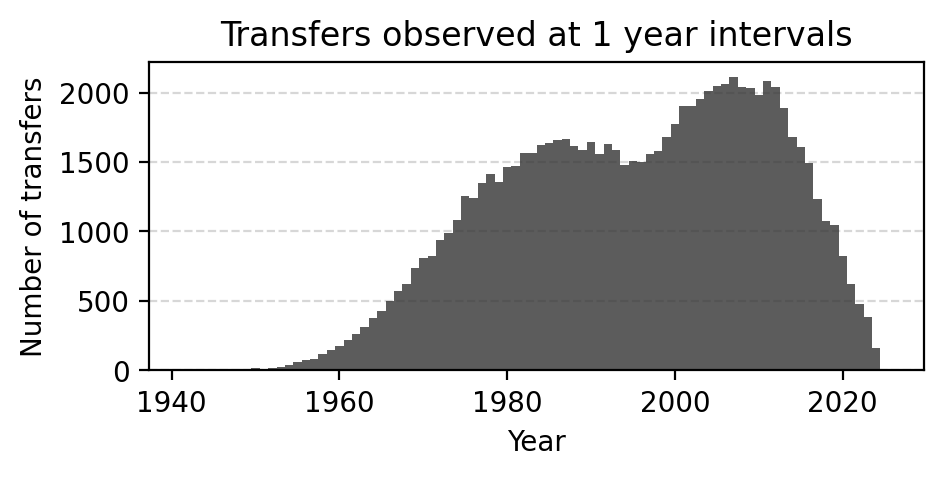

In [45]:
fig, ax = plt.subplots(1,1,figsize=(5,2),dpi=200)

ax.bar(aggregate_counts.index + tdf['timestamp'].min(), aggregate_counts.values, width=bin_size, color='.2', alpha=0.8)

ax.grid(axis="y", linestyle="--", alpha=0.5)
# Set x-ticks at absolute 24-hour intervals
start_time = aggregate_counts.index.min()
end_time = aggregate_counts.index.max()

# Generate 24-hour spaced timestamps
# tick_positions = range(start_time, end_time + 1, 24 * 3600)  # Step by 24 hours (in seconds)
#tick_labels = ['Day %i'%i for i in range(1,len(tick_positions)+1)]

# Set ticks and labels
# ax.set_xticks(tick_positions)
# ax.set_xticklabels(tick_labels)

ax.set_title("Transfers observed at %.0f year intervals"%(bin_size))
ax.set_xlabel("Year")
ax.set_ylabel("Number of transfers")

plt.show()

In [46]:
import os
import json
import pandas as pd

base_path = '../../physician_trajectories/data'
folders = [folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

In [47]:
folders

['neurosurgery',
 'medical_genetics',
 'card',
 'endocrinology',
 'allergy',
 'geriatrics',
 'int_radiology',
 'obgyn',
 'child_neurology',
 'gastroenterology',
 'ophthalmology',
 'colorectal_surgery',
 'dermatology',
 'psychiatry',
 'hematology']

In [48]:
import os
import json
import pandas as pd

base_path = '../../physician_trajectories/data'
folders = [folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

errors = 0
tdf_dict = {}  # Dictionary to store tdf for each folder

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    tdf = pd.DataFrame({'node_u': [], 'node_v': [], 'timestamp': []})
    print(f"Processing folder: {folder}")
    
    # Iterate through files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.json'):
            try:
                file_path = os.path.join(folder_path, file_name)
                with open(file_path, 'r') as f:
                    data = json.load(f)
                
                # Assuming the file name format includes the ID
                i = int(file_name.split('.')[0])

                num_insts = len(data[str(i)]['training'])
                if num_insts > 1:
                    training_data = data[str(i)]['training']
                    iterator = [[im, im + 1] for im in range(num_insts - 1)]
                    node_u, node_v, timestamp = [], [], []
                    for ix in iterator:
                        link_attrs_0 = list(list(training_data.values())[ix[0]].values())[0]
                        inst_0 = list(list(training_data.values())[ix[0]].keys())[0]
                        parsed_dict_0 = parse_training_data(link_attrs_0, inst_0, 0)
                        link_attrs_1 = list(list(training_data.values())[ix[1]].values())[0]
                        inst_1 = list(list(training_data.values())[ix[1]].keys())[0]
                        parsed_dict_1 = parse_training_data(link_attrs_1, inst_1, 1)
                        if parsed_dict_1['end']:
                            timestamp.append(parsed_dict_1['end'])
                            node_u.append(inst_1)
                            node_v.append(inst_0)
                    df = pd.DataFrame({'node_u': node_u, 'node_v': node_v, 'timestamp': timestamp})
                    tdf = pd.concat([tdf, df], ignore_index=True)
            except Exception as e:
                print(f"[Error] Error processing file {file_name} in folder {folder}: {e}")
                errors += 1
                continue
    
    tdf_dict[folder] = tdf  # Store the tdf for this folder
    print(f"Completed processing folder: {folder}. Total rows in tdf: {len(tdf)}")

# Example: Access the tdf for a specific folder
# print(tdf_dict['card'])



Processing folder: neurosurgery
[Error] Error processing file failed_urls25.json in folder neurosurgery: invalid literal for int() with base 10: 'failed_urls25'
[Error] Error processing file failed_urls109.json in folder neurosurgery: invalid literal for int() with base 10: 'failed_urls109'
[Error] Error processing file 4267.json in folder neurosurgery: string indices must be integers, not 'str'
[Error] Error processing file 791.json in folder neurosurgery: string indices must be integers, not 'str'
[Error] Error processing file failed_urls72.json in folder neurosurgery: invalid literal for int() with base 10: 'failed_urls72'
[Error] Error processing file failed_urls64.json in folder neurosurgery: invalid literal for int() with base 10: 'failed_urls64'
[Error] Error processing file failed_urls148.json in folder neurosurgery: invalid literal for int() with base 10: 'failed_urls148'
[Error] Error processing file failed_urls33.json in folder neurosurgery: invalid literal for int() with ba

In [51]:
tdf_dict['neurosurgery']

,node_u,node_v,timestamp
0,National Capital Consortium,National Capital Consortium,1972.0
1,National Capital Consortium,National Capital Consortium,1968.0
2,Albany Medical College,National Capital Consortium,1967.0
3,University of Texas Health Science Center San ...,University of Washington,2003.0
4,University of Texas Health Science Center San ...,University of Texas Health Science Center San ...,1999.0
...,...,...,...
16407,Johns Hopkins University,University of California San Diego School of M...,2014.0
16408,Duke University Hospital,Duke University Hospital,2003.0
16409,Duke University School of Medicine,Duke University Hospital,2002.0
16410,NYU Grossman School of Medicine,NYU Grossman School of Medicine,2006.0


In [56]:
for i, folder in enumerate(folders):
    print(i//3, i%3)

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
3 0
3 1
3 2
4 0
4 1
4 2


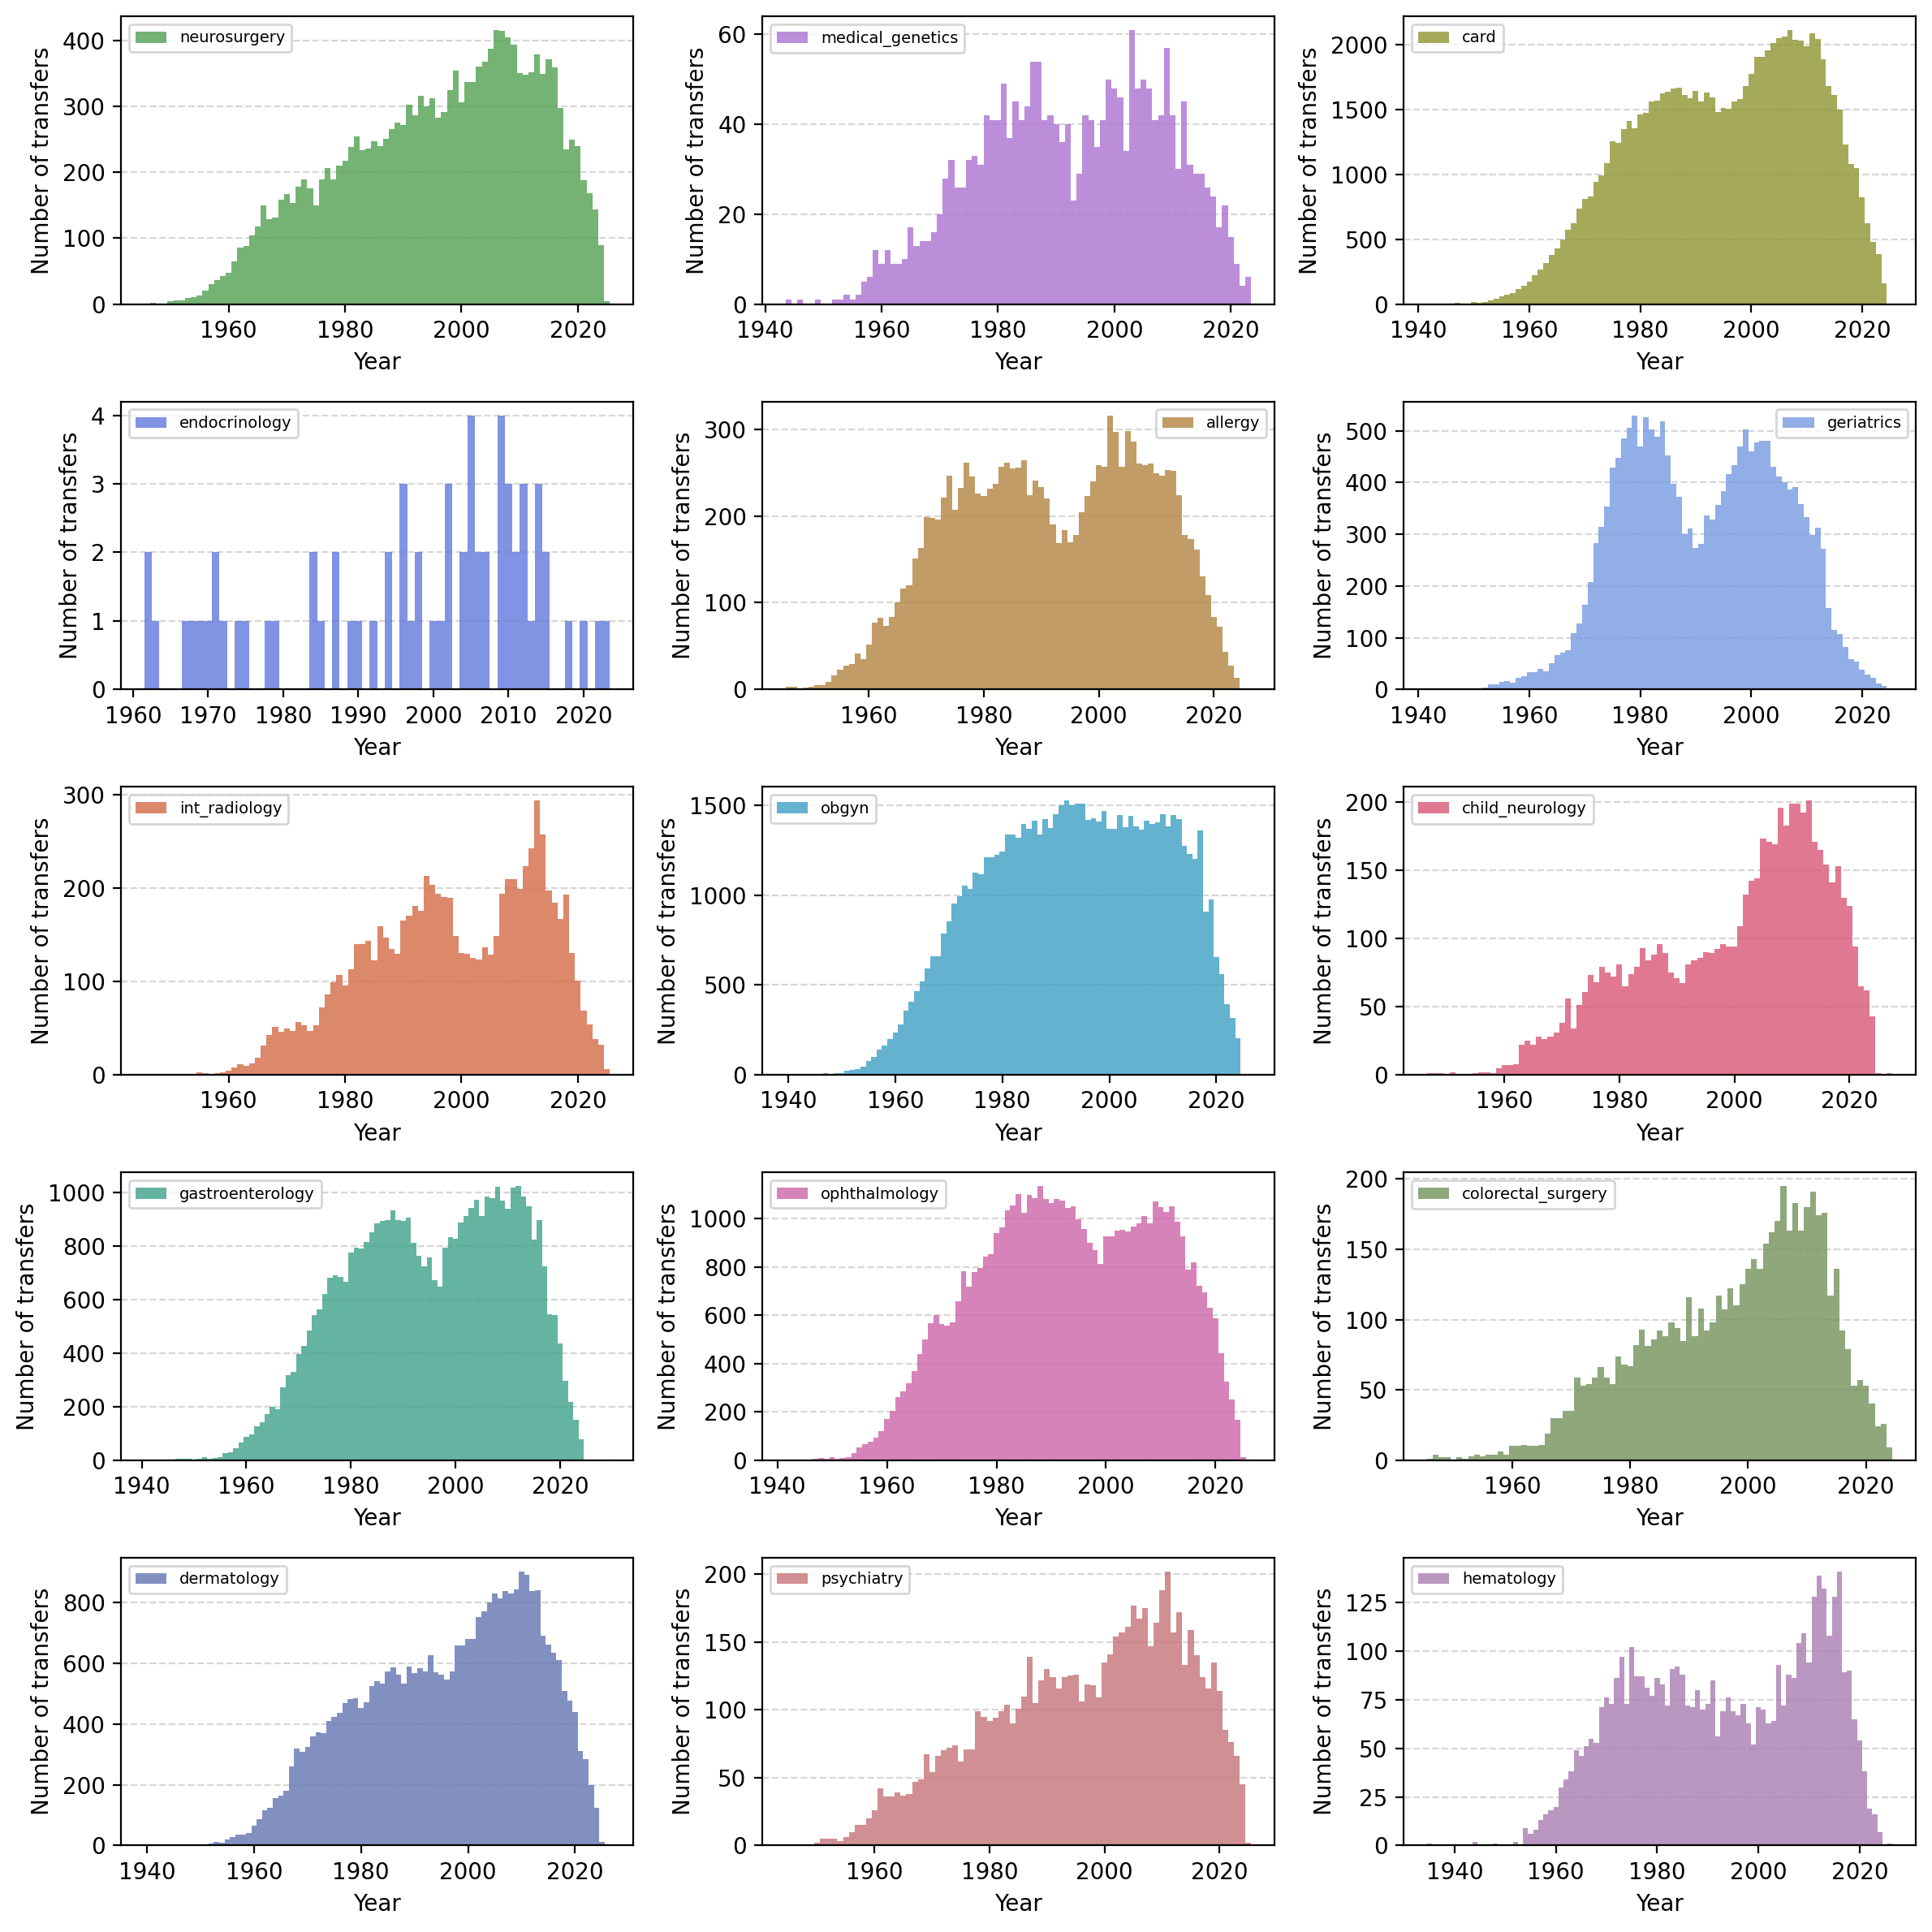

In [66]:
import matplotlib.cm as cm
fig, ax = plt.subplots(5,3,figsize=(12,12),dpi=200)

cols = ["#51a050",
"#ab72d0",
"#8f9532",
"#6079dc",
"#b28340",
"#769ae1",
"#d26a46",
"#3d9fc5",
"#da5676",
"#3fa18a",
"#cc64a8",
"#72925b",
"#6374b2",
"#c57378",
"#a97db2"]

for i, folder in enumerate(folders):
    tdf = tdf_dict[folder]
    tdf['time_elapsed'] = tdf['timestamp'] - tdf['timestamp'].min()
    tdf["time_bin"] = (tdf['time_elapsed'] // bin_size) * bin_size
    aggregate_counts = tdf["time_bin"].value_counts().sort_index()
    ax[i//3, i%3].bar(aggregate_counts.index + tdf['timestamp'].min(), aggregate_counts.values, width=bin_size, color=cols[i], alpha=0.8, label=folder)

    ax[i//3, i%3].grid(axis="y", linestyle="--", alpha=0.5)

    start_time = aggregate_counts.index.min()
    end_time = aggregate_counts.index.max()

    # ax[i//3, i%3].set_title("Transfers observed at %.0f year intervals"%(bin_size))
    ax[i//3, i%3].set_xlabel("Year")
    ax[i//3, i%3].set_ylabel("Number of transfers")
    ax[i//3, i%3].legend(fontsize=7)

plt.tight_layout()

plt.savefig('../figs/transfer_counts.png', dpi=425, bbox_inches='tight')
plt.savefig('../figs/transfer_counts.pdf', dpi=425, bbox_inches='tight')